# Import Libraries and Files

In [1]:
from DiscreteDeepRobots import ThreeLinkRobot
from math import pi, log
from mpl_toolkits.mplot3d import Axes3D
import random
import numpy as np
import pandas as pd
import copy
%matplotlib notebook
# %matplotlib inline
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor

Using TensorFlow backend.


# Q-Learning and Auxiliary Functinos

In [2]:
def Qlearner(num_robots, alpha, gamma, epsilon, angle_range, angle_interval, graphs = False, live_graphs = False, Qvalues=None):
    """
    :param num_robots: number of robots
    :param alpha: learning rate
    :param gamma: discount rate
    :param epsilon: probability of choosing random action while learning
    :param angle_range: (theta_lower,theta_upper,a1_lower,a1_upper,a2_lower,a2_upper,a_lower,a_upper)
    :param angle_interval: interval of state and action space
    :param graphs: whether to generate graphs
    :param live_graphs: whether to generate dynamics graphs
    :return: a tuple of learned q-values, states, actions
    """

    # initialize state space, action space, and Qvalues
    print('Qlearner initiated')
    print('loading state space')
    states = get_state_space(angle_range, angle_interval)  # state = (theta, a1, a2)
    print(len(states), 'states loaded')
    print('loading action space')
    actions = get_action_space(angle_range[6], angle_range[7], angle_interval)  # action = (a1dot, a2dot)
    print(len(actions), 'actions loaded')
    if Qvalues is None:
        Qvalues = {}
        print('initializing Qvalues')
        for state in states:
            for action in actions:
                Qvalues[(state, action)] = 0
        print(len(Qvalues.keys()), 'q-values loaded')
    else:
        print('Pretrained Qvalues loaded')

    # learn q-values
    print('\n\n')
    details = {}
    
    for j in range(num_robots):
        # print(j+1, ' ith ', 'robot is learning')
        state = random.choice(states)
        robot = ThreeLinkRobot(x=0, 
                               y=0, 
                               theta=state[0], 
                               a1=state[1],
                               a2=state[2],
                               link_length=2, 
                               t_interval=0.01, 
                               a_interval=angle_interval)
        i = 0
        
        # plotting
        xs = [robot.x]
        a1s = [robot.a1]
        a2s = [robot.a2]
        timesteps = [i]
        
        while True:
            i += 1
            # print('For', j, 'th robot', 'In', i, 'th iteration the initial state is: ', state)
            # employ an epsilon-greedy strategy for exploration vs exploitation
            best_actions = []
            if random.random() < epsilon:

                # choose a random action
                best_actions = actions
                # randomly select a tie-breaking, valid action
                while True:
                    best_action = random.choice(best_actions)
                    # print('The action randomly chosen is', best_action)
                    temp_robot = copy.deepcopy(robot)
                    temp_robot.move(best_action[0], best_action[1], 1)
                    if (temp_robot.theta, temp_robot.a1, temp_robot.a2) in states:
                        break
            else:

                # find the best actions (the ones with largest q-value)
                maxQ = -float("inf")
                for action in actions:
                    Q = Qvalues[(state, action)]
                    
                    # identify action with higher Q value
                    temp_robot = copy.deepcopy(robot)
                    if Q > maxQ:
                        
                        # check if action is valid
                        temp_robot.move(action[0], action[1], 1)
                        if (temp_robot.theta, temp_robot.a1, temp_robot.a2) in states:
                            best_actions = [action]
                            maxQ = Q
                    elif Q == maxQ:
                        temp_robot.move(action[0], action[1], 1)
                        if (temp_robot.theta, temp_robot.a1, temp_robot.a2) in states:
                            best_actions.append(action)
                    del temp_robot
                
                # randomly select a tie-breaking, valid action
                best_action = random.choice(best_actions)


            # print('In', i, 'th iteration the best action is: ', best_action)
            robot.move(best_action[0],best_action[1],1)

            # transition to new state
            new_state = robot.state
            # print('In', i, 'th iteration the new state is: ', new_state)
            
            # add values to lists
            xs.append(robot.x)
            a1s.append(robot.a1)
            a2s.append(robot.a2)
            timesteps.append(i)

            # plotting
            if live_graphs:
                make_graphs(xs,a1s,a2s,timesteps,j+1,live=True, Q=True)    

            # find the maximum Q value for new state
            Q = -float("inf")
            for action in actions:
                Q = max(Q, Qvalues[(new_state, action)])

            # find the reward of this transition
            reward = 0
            a1, a2, R, v, a1dot, a2dot = robot.a1, robot.a2, robot.R, robot.body_v[0], robot.a1dot, robot.a2dot
            
            '''
            # penalize according to joint proximity
            if a1 == a2:
                reward += -10*R
            
            else:
                print('In ', i, 'th iteration the penalty for joint angle proximity is: ', log(a1-a2), 'for joint angles: ', a1, a2)
                reward += log(a1-a2)
            '''
            
            # print('In ', i, 'th iteration the reward for x- velocity is: ', v/(a1dot**2 + a2dot**2), 'for velocity, a1dot, a2dot: ', v, a1dot, a2dot)
            reward += v/(a1dot**2 + a2dot**2)

            # TD update
            sample = gamma * Q
            old_Q = Qvalues[(state, best_action)]
            # print('In ', i, 'th iteration the Q value before update is: ', old_Q)
            new_Q = (1 - alpha) * old_Q + alpha * (reward + sample)
            Qvalues[(state, best_action)] = new_Q
            # print('In ', i, 'th iteration the Q value after update is: ', new_Q)
            state = new_state

            # check for convergence
            if old_Q == 0:
                pass
            elif abs((new_Q-old_Q)/old_Q) <= 0.05:
                print(j+1, ' th ', 'robot RL converged')
                break
        if graphs:
            make_graphs(xs, a1s, a2s, timesteps, j,Q=True)
        details[j] = (xs, a1s, a2s, timesteps)
        
    return Qvalues, states, actions, details

In [3]:
def get_action_space(lower_limit, upper_limit, interval):
    """
    auxiliary function used by Qlearner() to get action space
    :return: a list of action space values in tuple format (a1dot, a2dot)
    """
    upper_limit += (interval/10)  # to ensure the range covers the rightmost value in the loop
    r = np.arange(lower_limit, upper_limit, interval)
    space = [(rnd(i), rnd(j)) for i in r for j in r]

    # remove a1dot = 0, a2dot = 0 from action space
    space.remove((0,0))

    return space


def get_state_space(angle_range, angle_interval):
    """
    auxiliary function used by Qlearner() to get action space
    :param angle_range: (theta_lower,theta_upper,a1_lower,a1_upper,a2_lower,a2_upper,a_lower,a_upper)
    :return: a list of state space values in tuple format (a1, a2, theta)
    """
    theta_lower,theta_upper,a1_lower,a1_upper,a2_lower,a2_upper,a_lower,a_upper = angle_range
    
    # to ensure the range covers the rightmost value in the loop
    theta_upper += (angle_interval/10)
    a1_upper += (angle_interval/10)
    a2_upper += (angle_interval/10)

    theta_range = np.arange(theta_lower, theta_upper, angle_interval)
    a1_range = np.arange(a1_lower, a1_upper, angle_interval)
    a2_range = np.arange(a2_lower, a2_upper, angle_interval)
    space = [(rnd(theta), rnd(a1), rnd(a2)) for theta in theta_range for a1 in a1_range for a2 in a2_range]

    return space
def rnd(number):
    return round(number, 8)

In [4]:
def make_graphs(xs, a1s, a2s, timesteps, robot_num, live=False, Q=False):
    # plotting
    fig1 = plt.figure(1)
    if Q:
        fig1.suptitle('Q-learning Monitor for robot ' + str(robot_num))
    else:
        fig1.suptitle('Policy Rollout')
    ax1 = fig1.add_subplot(311)
    ax2 = fig1.add_subplot(312)
    ax3 = fig1.add_subplot(313)
    fig2 = plt.figure(2)
    ax4 = fig2.add_subplot(111, projection='3d')
    
    ax1.plot(timesteps, xs, '.-')
    ax1.set_ylabel('x')
    ax2.plot(timesteps, a1s, '.-')
    ax2.set_ylabel('a1')
    ax3.plot(timesteps, a2s, '.-')
    ax3.set_ylabel('a2')
    
    ax4.set_title('3D Monitor for a1, a2 vs time')
    ax4.plot(timesteps, a1s, a2s, '.-')
    fig1.tight_layout()
    fig2.tight_layout()
    plt.tight_layout()
    plt.show()
 

# Policy and Q-value Testing Functions

In [5]:
def extract_policy(model, states, actions, Qvalues = None):
    policy = {}
    if model is not None:
        for state in states:
            maxQ = -float("inf")
            best_action = None
            for action in actions:
                feature = [val for val in state]
                for val in action: 
                    feature.append(val)
                Q = model.predict(np.array([np.array(feature)]))
                maxQ = max(Q, maxQ)
                if Q == maxQ:
                    best_action = action
            policy[state] = best_action
    else:
        for state in states:
            maxQ = -float("inf")
            best_action = None
            for action in actions:
                Q = Qvalues[(state, action)]
                maxQ = max(Q, maxQ)
                if Q == maxQ:
                    best_action = action
            policy[state] = best_action
    return policy


def test_policy(robot, policy, timestep=20):
    dx = 0
    dxs = []
    a1s = []
    a2s = []
    timesteps = []
    plt.title('Policy Rollout')
    for i in range(timestep):
        
        # rollout
        initial_state = robot.state
        print('In', i+1, 'th iteration the initial state is: ', initial_state)
        old_x = robot.x
        action = policy[initial_state]
        print('In', i+1, 'th iteration the chosen action is: ', action)
        robot.move(action[0], action[1], 1)
        new_x = robot.x
        print('In ', i+1, 'th iteration, the robot moved ', new_x - old_x, ' in x direction')
        dx += (new_x-old_x)
        
        # add values to lists
        dxs.append(dx)
        a1s.append(robot.a1)
        a2s.append(robot.a2)
        timesteps.append(i)
        
        # plotting
        make_graphs(dxs,a1s,a2s,timesteps,0,live=True)
        
        plt.plot(a1s,a2s,'.-')
        plt.xlabel('a1')
        plt.ylabel('a2')
        plt.show()
        
        
    plt.show()
    return dx

# Functional Approximation Functions

In [6]:
def get_training_inputs(Qvalues):
    X, Y = [], []
    for key in Qvalues:
        if Qvalues[key] == 0:
            continue
        else:
            feature = []
            for element in key:
                for val in element:
                    feature.append(val)
            X.append(np.array(feature))
            Y.append(Qvalues[key])
    X, Y = np.array(X),np.array(Y)
    return X, Y

In [7]:
# fill in null Q values with Random Forest Predictions
def fill_Q(Qvalues, model):
    i = 1
    for key in Qvalues:
        if Qvalues[key] != 0:
            continue
        else:
            state_action = []
            for element in key:
                for val in element:
                    state_action.append(val)
            Q = model.predict(np.array([np.array(state_action)]))
            Qvalues[key] = Q[0]
        print(i,'/',len(Qvalues),' Qvalues predicted')
        i += 1
    return Qvalues

### Neural Networks Functions

In [8]:
# plot history function
def plot_history(history):
    # acc = history.history['acc']
    # val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    #plt.subplot(1, 2, 1)
    # plt.plot(x, acc, 'b', label='Training acc')
    # plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation loss')
    # plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.legend()
    plt.show()
    plt.close()

In [9]:
# early stopping is used to prevent overtraining -> we will stop the training "early" if it has reached maximum accuracy
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto',restore_best_weights=True)
callbacks_list = [early_stopping]

### Training Neural Network

In [10]:
def train_NN(X,Y):
    # specify the input and output dimensions of the neural network
    input_dim = 5
    output_dim = 1

    model = Sequential()
    # input layer
    model.add(Dense(input_dim, input_dim=input_dim, activation = 'relu'))
    # hidden layers
    model.add(Dense(300, activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))
    # output layer
    model.add(Dense(output_dim, activation = 'linear'))
    # Compile the architecture and view summary
    model.compile(loss='mse',optimizer='adam')
    history = model.fit(X, Y,
                        epochs=20,
                        verbose=1,
                        validation_data = (X, Y),
                        callbacks=callbacks_list,
                        batch_size=8)
    print(model.summary())
    # print the loss of the model on training and validation set  
    loss = model.evaluate(X, Y, verbose=False)
    print("Training Loss: {:.4f}".format(loss))
    # plot history
    %matplotlib inline
    plot_history(history)
    return model

# Testing

In [11]:
def periodic_test(iterations=150, angle_range=(-pi/8,pi/8,pi/32,pi/8,-pi/8,-pi/32,-pi/8,pi/8), angle_interval=pi/32, period=3, method='RL'):
    # learn Q values
    print('Begin Function Approximation in period ', 1)
    Qvalues, states, actions, _ = Qlearner(num_robots=iterations,
            alpha=0.5,
            gamma=0.9,
            epsilon=0.5,
            angle_range = angle_range,
            angle_interval=angle_interval,
            graphs=False,
            live_graphs=False)
    for i in range(period-1):
        print('Begin Function Approximation in period ', i+2)
        X, Y = get_training_inputs(Qvalues)
        if method == 'RL':
            # Random Forest
            rf = RandomForestRegressor(n_estimators = 100)
            rf.fit(X, Y)
            # Calculate MAE
            predictions = rf.predict(X)
            errors = abs(predictions - Y)
            print('Mean Absolute Error:', round(np.mean(errors), 2))
            print('Making Q value predictions...')
            Qvalues = fill_Q(Qvalues=Qvalues, model=rf)
            print('Q value predictions done')
        else:
            #NN
            NN = train_NN(X,Y)
            print('Making Q value predictions...')
            Qvalues = fill_Q(Qvalues=Qvalues, model=NN)
            print('Q value predictions done')
            
        Qvalues, states, actions, _ = Qlearner(num_robots=iterations,
            alpha=0.5,
            gamma=0.9,
            epsilon=0.5,
            angle_range = angle_range,
            angle_interval=angle_interval,
            graphs=False,
            live_graphs=False,
            Qvalues=Qvalues)
    
    # extract policy
    policy = extract_policy(model=None, states=states, actions=actions, Qvalues=Qvalues)
    robot = ThreeLinkRobot(x=0,
                       y=0,
                       theta=pi/32,
                       a1=pi/16,
                       a2=-pi/16,
                       link_length=2,
                       t_interval=0.001,
                       a_interval=angle_interval)
    %matplotlib inline
    x_displacement = test_policy(robot=robot, policy=policy, timestep=100)

Begin Function Approximation in period  1
Qlearner initiated
loading state space
833 states loaded
loading action space
288 actions loaded
initializing Qvalues
239904 q-values loaded



1  th  robot RL converged
2  th  robot RL converged
3  th  robot RL converged
4  th  robot RL converged
5  th  robot RL converged
6  th  robot RL converged
7  th  robot RL converged
8  th  robot RL converged
9  th  robot RL converged
10  th  robot RL converged
11  th  robot RL converged
12  th  robot RL converged
13  th  robot RL converged
14  th  robot RL converged
15  th  robot RL converged
16  th  robot RL converged
17  th  robot RL converged
18  th  robot RL converged
19  th  robot RL converged
20  th  robot RL converged
21  th  robot RL converged
22  th  robot RL converged
23  th  robot RL converged
24  th  robot RL converged
25  th  robot RL converged
26  th  robot RL converged
27  th  robot RL converged
28  th  robot RL converged
29  th  robot RL converged
30  th  robot RL converged
31  th  robot

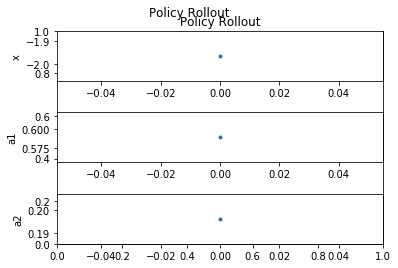

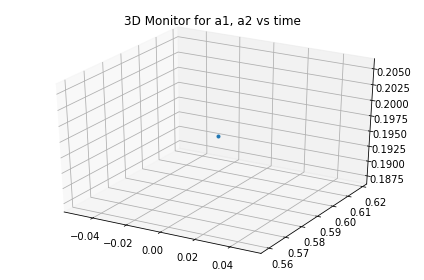

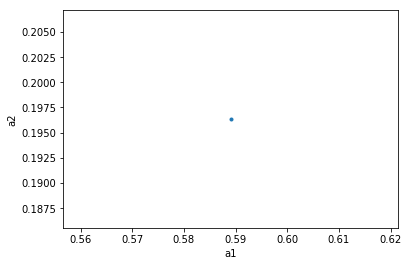

In 2 th iteration the initial state is:  (-0.29452431, 0.58904862, 0.19634954)


KeyError: (-0.29452431, 0.58904862, 0.19634954)

In [12]:
periodic_test(angle_interval=pi/64,period=1)